В этом проекте попробуем узнать как количество активных клиентов влияет на нагрузку отдела Support и предсказать количество обращений при увеличении числа активных клиентов до 30 000 в месяц.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas import Series
pd.options.mode.chained_assignment = None
import plotly.express as px
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import pprint

In [2]:
intercom2020 = pd.read_csv('/content/inbox-data-export.csv') #выгрузка по диалогам за 2020
transactions = pd.read_csv('/content/transactions.csv') #активные клиенты и их транзакции с момента запуска карточной программы

In [3]:
intercom2020['Created at'] = pd.to_datetime(intercom2020['Created at'])
transactions['created_at'] = pd.to_datetime(transactions['created_at'])

In [4]:
intercom_from_august = intercom2020[(intercom2020['Created at'] > 
                                     '2020-08-01T00:50:03.286012') & 
                                    (intercom2020['Created at'] < 
                                     '2021-01-01T00:50:03.286012')]
transactions_2020 = transactions[transactions['created_at'] < '2021-01-01']

## Найдем процент обращений от активных клиентов среди всех обращений по месяцам и построим модель для предсказания количества активных клиентов, которые обратятся в саппорт.

In [5]:
intercom_from_august['If_user'] = intercom_from_august['User ID'].str.isdigit()
intercom_users = intercom_from_august[intercom_from_august['If_user'] == True]
transactions_2020 = transactions_2020.reset_index(drop=True)
transactions_2020.columns = ['User ID', 'created_at', 'reference_type']
intercom_users['User ID'] = intercom_users['User ID'].astype(int)
transactions_2020['User ID'] = transactions_2020['User ID'].astype(int)

In [6]:
#найдем уникальнык User ID активных клиентов и клиентов обратившихся в поддержку за период
def create_sets_of_users(active_by_period, intercom_by_period, column_name, unique_periods):
  d_interc = {} 
  d_trans = {}
  for i in range(min(unique_periods), max(unique_periods) + 1):
    temp = intercom_by_period.loc[i,].reset_index()
    temp2 = active_by_period.loc[i,].reset_index()
    d_interc[i] = set(temp['User ID'])
    d_trans[i] = set(temp2['User ID'])
  return d_interc, d_trans

In [7]:
#найдем % активных клиентов из всех клиентов обратившихся в саппорт
def calculate_percent_of_active(d_interc, d_trans, unique_periods):
  percent_of_active_by_period = {} 
  for i in range(min(unique_periods), max(unique_periods) + 1):
    intersection = d_interc[i].intersection(d_trans[i])
    percent_of_active_by_period[i] = round(len(intersection)/len(d_interc[i]) * 100)
  return percent_of_active_by_period

In [8]:
def plot_bar(percent_of_active_by_period):
  plt.figure(figsize=(10,6))
  plt.bar(range(len(percent_of_active_by_period)), list(percent_of_active_by_period.values()), align='center')
  plt.xticks(range(len(percent_of_active_by_period)), list(percent_of_active_by_period.keys()))
  plt.title('% активных клиентов, обратившихся в поддержку')
  plt.xlabel('Интервал')
  plt.ylabel('%')

  plt.show()

In [9]:
#тут число активных клиентов и количество активных клиентов обратившихся в саппорт
def create_dict_for_lin_r(d_interc, d_trans, unique_periods):
  d_intersec_period = {} 
  for i in range(min(unique_periods), max(unique_periods) + 1):
    intersection = d_interc[i].intersection(d_trans[i])
    d_intersec_period[len(d_trans[i])] = len(intersection)
  return d_intersec_period

In [10]:
# посмторим модель лтнейной регрессии
def perform_linear_regression(d_intersec_period):
  X = np.array(list(d_intersec_period.keys())).reshape(-1, 1)  # values converts it into a numpy array

  Y = np.array(list(d_intersec_period.values())).reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

  linear_regressor = LinearRegression()  # create an instance of the class

  linear_regressor.fit(X, Y)  # perform linear regression

  Y_pred = linear_regressor.predict(X)  # make predictions

  plt.figure(figsize=(10,6))
  plt.scatter(X,Y)

  plt.plot(X,Y_pred, c='red')
  

  plt.title('График линейной регрессии')
  plt.xlabel('Количество активных клиентов (ак)')
  plt.ylabel('Количество ак, обратившихся в саппорт ')
  
  plt.show()

  print('Средняя квадратичная ошибка:', mse(Y, Y_pred))

  return linear_regressor

In [11]:
# функция, которая включает в себя все предыдущие и показывает результат 
def calculate_linear_regression(granularity):
  column_name = 'Created_at_' + granularity
  if granularity == 'month':
    transactions_2020[column_name] = transactions_2020['created_at'].dt.month
    intercom_users[column_name] = intercom_users['Created at'].dt.month
  elif granularity == 'week':
    transactions_2020[column_name] = transactions_2020['created_at'].dt.week
    intercom_users[column_name] = intercom_users['Created at'].dt.week
  elif granularity == 'day':
    transactions_2020[column_name] = transactions_2020['created_at'].dt.dayofyear
    intercom_users[column_name] = intercom_users['Created at'].dt.dayofyear
  elif granularity == 'fifth':
    transactions_2020['day_num'] = transactions_2020['created_at'].dt.dayofyear
    intercom_users['day_num'] = intercom_users['Created at'].dt.dayofyear
    intercom_by_day = intercom_users.pivot_table(index=['day_num', 'User ID'], values='Created at', aggfunc='count').reset_index()
    step = np.array_split(np.array(intercom_by_day['day_num'].unique()), round((366-229) / 5))
    step = [list(i) for i in step]
    d = {}
    for i in range(len(step)):
      for j in step[i]:
        d[j] = i
    transactions_2020[column_name] = [d[i] for i in transactions_2020['day_num']]
    intercom_users[column_name] = [d[i] for i in intercom_users['day_num']]
  else:
    return 'Unknown Granularity'

  active_by_period = transactions_2020.pivot_table(index=[column_name, 'User ID'], values='created_at', aggfunc='count')
  intercom_by_period = intercom_users.pivot_table(index=[column_name, 'User ID'], values='Conversation ID', aggfunc='count')
  unique_periods = list(active_by_period.reset_index()[column_name].unique())

  d_interc, d_trans = create_sets_of_users(active_by_period, intercom_by_period, column_name, unique_periods)

  percent_of_active_by_period = calculate_percent_of_active(d_interc, d_trans, unique_periods)

  plot_bar(percent_of_active_by_period)
  d_intersec_period = create_dict_for_lin_r(d_interc, d_trans, unique_periods)
  print('Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале')
  pp = pprint.PrettyPrinter(indent=4)
  pp.pprint(percent_of_active_by_period)
  print('Средний процент активных клиентов из всех обратившихся', round(np.array(list(percent_of_active_by_period.values())).mean(), 2))
  return perform_linear_regression(d_intersec_period)



## Прогноз на выборке с интервалом в 1 месяц

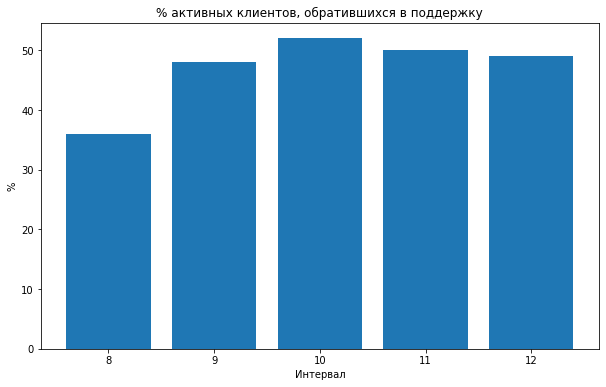

Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале
{8: 36, 9: 48, 10: 52, 11: 50, 12: 49}
Средний процент активных клиентов из всех обратившихся 47.0


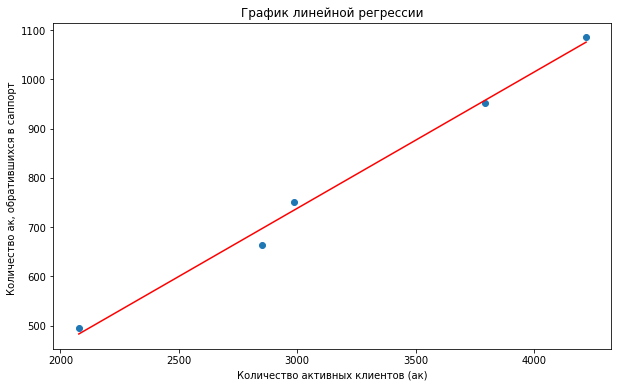

Средняя квадратичная ошибка: 327.35980481835253
Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 30 000 в месяц: 8211


In [12]:
lr_month = calculate_linear_regression('month')
print('Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 30 000 в месяц:', round(lr_month.predict(np.array([30000]).reshape(-1, 1))[0][0])) 


In [13]:
print('Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период:', round(100 / 47 * lr_month.predict(np.array([30000]).reshape(-1, 1))[0][0]))

Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период: 17471


## Прогноз на выборке с недельным интервалом

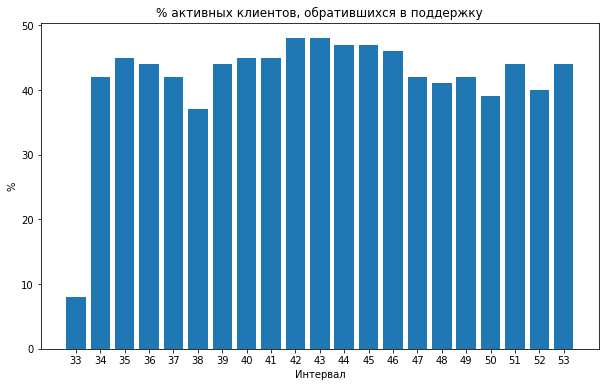

Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале
{   33: 8,
    34: 42,
    35: 45,
    36: 44,
    37: 42,
    38: 37,
    39: 44,
    40: 45,
    41: 45,
    42: 48,
    43: 48,
    44: 47,
    45: 47,
    46: 46,
    47: 42,
    48: 41,
    49: 42,
    50: 39,
    51: 44,
    52: 40,
    53: 44}
Средний процент активных клиентов из всех обратившихся 41.9


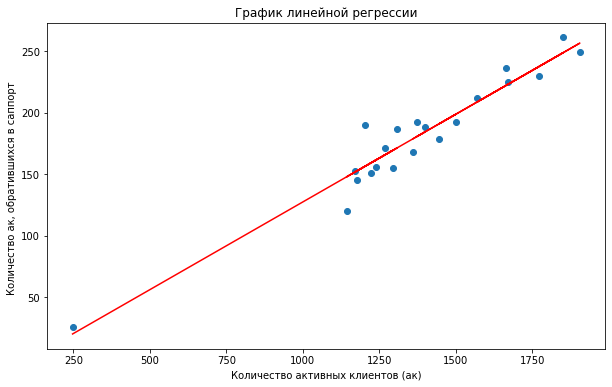

Средняя квадратичная ошибка: 166.26004487783834
Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 7 500 в неделю: 1052


In [14]:
lr_week = calculate_linear_regression('week')
print('Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 7 500 в неделю:', round(lr_week.predict(np.array([7500]).reshape(-1, 1))[0][0]))

In [15]:
print('Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период:', round(100 / 41.9 * lr_week.predict(np.array([7500]).reshape(-1, 1))[0][0])) 

Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период: 2511


## Проноз на выборке с интервалом в 5 дней

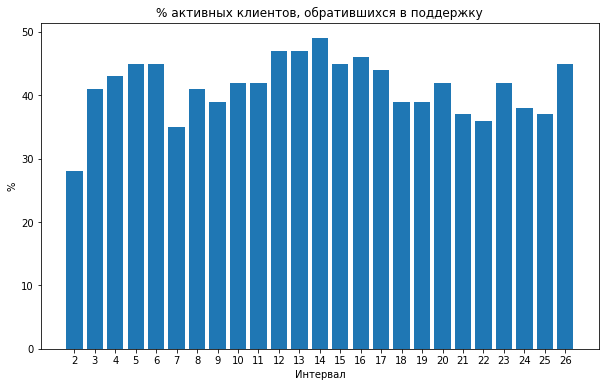

Процент активных клиентов из всех клиентов обратившихся в саппорт в каждом интервале
{   2: 28,
    3: 41,
    4: 43,
    5: 45,
    6: 45,
    7: 35,
    8: 41,
    9: 39,
    10: 42,
    11: 42,
    12: 47,
    13: 47,
    14: 49,
    15: 45,
    16: 46,
    17: 44,
    18: 39,
    19: 39,
    20: 42,
    21: 37,
    22: 36,
    23: 42,
    24: 38,
    25: 37,
    26: 45}
Средний процент активных клиентов из всех обратившихся 41.36


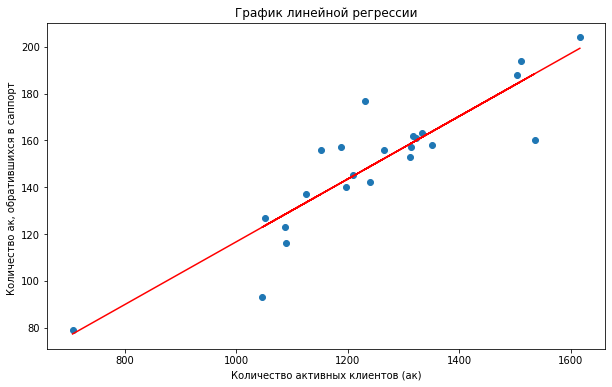

Средняя квадратичная ошибка: 158.30738035236928
Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 5 000 за 5 дней: 654


In [16]:
lr_five = calculate_linear_regression('fifth')
print('Ожидаемое количество активных клиентов, которые обратятся в поддержку при общем количестве активных клиентов 5 000 за 5 дней:', round(lr_five.predict(np.array([5000]).reshape(-1, 1))[0][0])) 

In [17]:
print('Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период:', round(100 / 41.36 * lr_five.predict(np.array([5000]).reshape(-1, 1))[0][0])) 

Ожидаемое количество всех клиентов, обратившихся в саппорт за рассматриваемый период: 1580
